In [1]:
import matplotlib.pyplot as plt
import arviz as az
import numpy as np

# move to previouse directory to access the privugger code
import os, sys
sys.path.append(os.path.join("../../"))

import privugger as pv

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Example of using Privugger on OpenDP 

This tutorial shows the use of privugger on a program using the differential privacy libray [OpenDP](https://github.com/opendp).

## OpenDP program

We consider a program that takes as input a dataset with attributes: age, sex, education, race, income and marriage status. The program outputs the mean of the incomes and adds Laplacian noise to protects the individuals privacy.

For each attribute, the program takes a parameter of type array (int or float) with the attribute value for each individual in the dataset. For example, to model a dataset of size 2 where the first individual is 20 and the second is 40, we set the `age` input parameter as `age=[20,40]`. The remaining parameters are defined in the same way. The last parameter `N` indicates the number of records in the dataset.

This way of defining the input may seem unnatural, but, as we will see below, it allows for a structured manner to specify the prior of the program.

Furthermore, note that the first lines of `dp_program` simply defined a pandas dataframe. This snippet of code can be adapted to other programs. The part of the code after the comment `## After here the...` can contain arbitrary code working on a pandas dataframe with the attributes defined in the parameters of the program.

In [2]:
def dp_program(age, sex, educ, race, income, married, N):
    import opendp.smartnoise.core as sn
    import pandas as pd

    # assert that all vectors are have the same size
    assert age.size == sex.size == educ.size == race.size == income.size == married.size
    
    ## Dataframe definition (can be automatized)
    temp_file='temp.csv'
    var_names = ["age", "sex", "educ", "race", "income", "married"]
    data = {
        "age":     age,
        "sex":     sex,
        "educ":    educ,
        "race":    race,
        "income":  income,
        "married": married
    }
    df = pd.DataFrame(data,columns=var_names)
    
    ## After here the program works on a pandas dataframe
    df.to_csv(temp_file)
    with sn.Analysis() as analysis:
        # load data
        data = sn.Dataset(path=temp_file,column_names=var_names)

        # get mean income with laplacian noise (epsilon=.1 arbitrarily chosen)
        age_mean = sn.dp_mean(data = sn.to_float(data['income']),
                              privacy_usage = {'epsilon': .1},
                              data_lower = 0., # min income
                              data_upper = 200., # max income                   
                              data_rows = N
                             )
    analysis.release()
    return np.float64(age_mean.value)   

## Input specification

The next step is to specify the prior knowledge of the attacker using probability distributions (i.e., they are defined as _random variables_). In this example, we show specify each of the attributes that conform the dataset.

The variable `N` defines the size of the dataset (`N_rv` is a point distribution with all probability mass concentrated at `N`, this is necessary because the input specification must be composed by random variables). In this example, we consider a dataset of size 150.

For non-numeric attributes such as `sex`, `educ` or `race` we use distribution over natural numbers with each number denoting a category. We treat them as nominal values (i.e., we assume there is not order relation, $\leq$ among them). For these attributes (and `married`) we specify a uniform distribution over all possible categories.

For `age`, we set a binomial distribution prior with support 0 to 120; this distribution gives highest probability to ages close to 60 years old. We remak here that this prior may be refined by using statistical data about age data.

Finally, `income` is distributed according to a Normal distribution with mean 100 and standard deviation 5. This gives high probability to values close to 100 (i.e., 100k DKK).

In [3]:
N         = 150
N_rv      = pv.Constant('N', N)
age       = pv.Binomial('age', p=0.5, n=120, num_elements=N)
sex       = pv.DiscreteUniform('sex', 0,2,num_elements=N)
educ      = pv.DiscreteUniform('educ', 0,10, num_elements=N)
race      = pv.DiscreteUniform('race', 0,50, num_elements=N)
income    = pv.Normal('income', mu=100, std=5, num_elements=N)
married   = pv.DiscreteUniform('married', 0,1,num_elements=N)

## Dataset & Program specification  

The input specification above is always wrapped into a `Dataset` object. This object is used as the input for the program.

In [4]:
ds       = pv.Dataset(input_specs = [age, sex, educ, race, income, married, N_rv])

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [N]
>>Metropolis: [married]
>>Metropolis: [race]
>>Metropolis: [educ]
>>Metropolis: [sex]
>>Metropolis: [age]
>NUTS: [income]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 199 seconds.
/home/pardo/.local/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/.local/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


## Program specification

The program specification takes the `Dataset` above and the program to analyze. To this end, we define a `Program` object including the `Dataset`, a python function corresponding to the program to analyze (the input parameters of the function must match those of the `Dataset`). Finally, it is necessary to specify the type of the output of the program. In this case, since we are analyzing a program compute the mean income it is a float. The first parameter of the `Program` constructor is the name of the output distribution (i.e., the distribution of the output of the program under analysis).

 output type specifies the output type of the program, in this case it is a floating point number as the program calulates the mean. The function is the program specified above. 

In [ ]:
program = pv.Program('output',dataset=ds, output_type=pv.Float, function=dp_program)

## Inference

Lastly we use the privug interface to perform the inference. This is done by calling `infer` and specifying the `program`, number of cores, number of chains, number of draws, and the backend (which is pymc3 in this example).

In [ ]:
trace = pv.infer(program, cores=4, chains=2, draws=20000, method='pymc3')

## Privacy Risk Analysis

### Mutual Information

To quantify privacy risks, in this tutorial we are using mutual information (though we remark here that privugger can be used to compute many more leakage measures).

We study the risks for the individual in the first record. We compute the mutual information between the output of the program (mean income + laplace noise) and each of the other attributes in the dataset.

Since the mutual informaiton estimator we use is not exact, we compute 100 estimates and use box plots to get an impresison of the accuracy of the estimates.

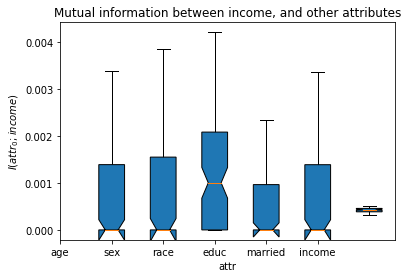

In [8]:
trace_length=20000
attrs=['age','sex','race','educ','married','income']

trace_attr = lambda attr : np.concatenate(trace.posterior[attr],axis=0)

y=[[pv.mi_sklearn([trace_attr(attr)[:trace_length,0], trace_attr('output')[:trace_length]],
                  n_neigh=40,input_inferencedata=False)[0]
   for attr in attrs] for i in range(0,100)]

plt.boxplot(np.array(y),attrs,
            showmeans=False, showfliers=False, patch_artist=True, vert=True)
plt.xticks(range(0,len(attrs)), attrs)
plt.xlabel('attr')
plt.ylabel('$I(attr_0;income)$')
plt.title("Mutual information between income, and other attributes")
plt.show();

In the figure above, we observe that the mutual information between the output and any of the attributes is very low $I(\mathit{attr};\mathit{output})\leq 0.005$ for all attributes ($\mathit{attr}$).